# Demo

In [22]:
import financial.data as fd
import financial.model as fm

import numpy as np
import pandas as pd
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # INFO and WARNING messages are not printed (TensorFlow)

In [23]:
from financial.io.cache import NoUpdateStrategy
from financial.io.file.cache import FileCache

print(os.environ["DATA"])
print(os.environ["CACHE"])
ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))

print(ds)

/home/manidmt/Universidad/TFG/OTRI/data
/home/manidmt/Universidad/TFG/OTRI/cache
CachedDataStore with 946 data sources [cache stats: {'size': 0, 'hit': 0, 'miss': 0, 'write': 0, 'read': 0, 'update': 0}]


## Acceso a los datos

In [24]:
# Datos históricos de un ticker concreto, p.ej. ^GSPC (S&P 500)
start_date = '1990-01-01'
end_date = '2024-12-31'
ticker = 'AAPL'

data = ds.get_data(ticker, start_date, end_date)
print(data)

Date
1990-01-02      0.262129
1990-01-03      0.263889
1990-01-04      0.264769
1990-01-05      0.265649
1990-01-08      0.267408
                 ...    
2024-12-24    258.200012
2024-12-26    259.019989
2024-12-27    255.589996
2024-12-30    252.199997
2024-12-31    250.419998
Name: AAPL, Length: 8817, dtype: float64


AAPL, from 1990-01-02 to 2024-12-31


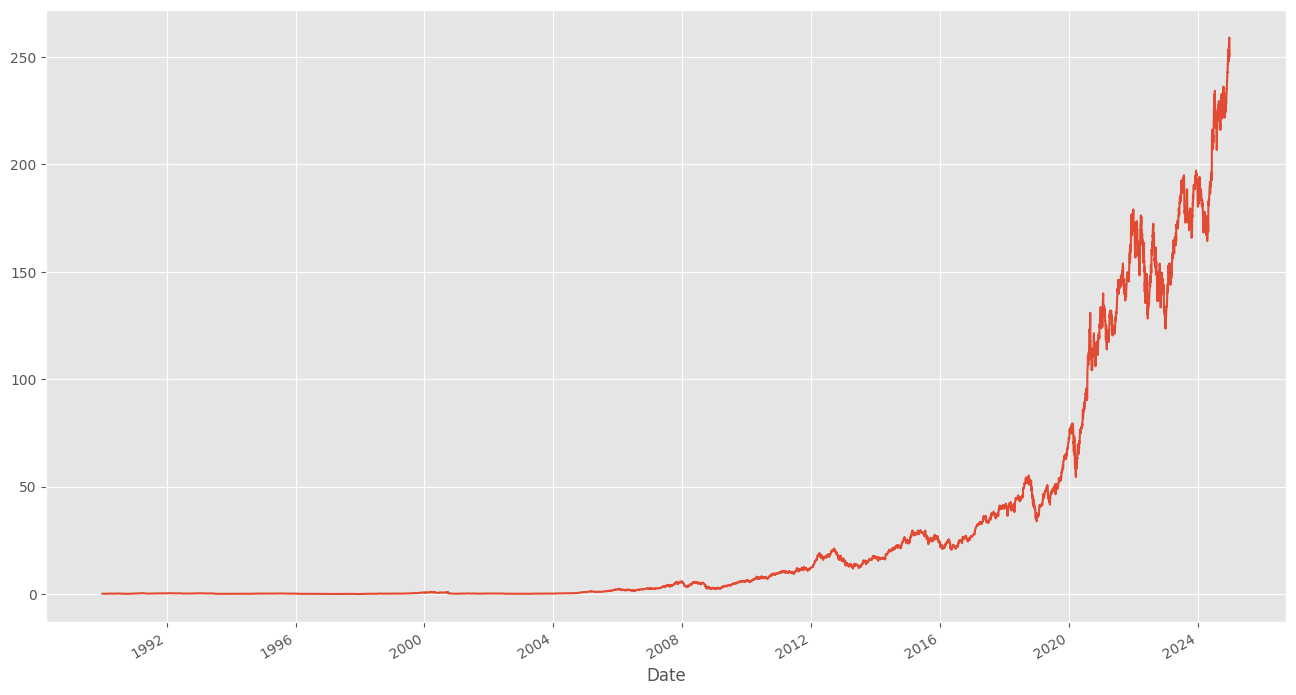

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')


def plot_data(data: pd.Series) -> None:
    data.plot()
    start_date = data.index[0].date()
    end_date = data.index[-1].date()
    print(f"{data.name}, from {start_date} to {end_date}")

plot_data(data)

# Hiperparámetros

In [26]:
# Declarative model specification

experiment_id = 'exponential-regression-model'
lookahead = 20 # i.e. ~ 1 mes (4 semanas)
horizon   = 90 # Clenow

hyperparameters = {
        "input": {
            "features": "local_regression_features_wrapper"
            # "normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },
        "output": {
            "target": [ticker],
            "lookahead": lookahead,
            "prediction": "relative" # "absolute"|"relative"
            # "normalization": { "method": "z-score", "start_index": start_date, "end_index": end_date }
            },    
}

print(f"Experiment '{experiment_id}'")
print(hyperparameters)

Experiment 'exponential-regression-model'
{'input': {'features': 'local_regression_features_wrapper'}, 'output': {'target': ['AAPL'], 'lookahead': 20, 'prediction': 'relative'}}


# E/S de un modelo autorregresivo

In [27]:
# Entradas 

def local_regression_features(ds: fd.DataStore, ticker: str) -> fd.Set:
    features = fd.Set('Local exponential regression model features')    
    variable = fd.Variable(ticker)
    features.append(variable)
    return features


print("MODEL INPUTS")
inputs = local_regression_features(ds,ticker)
print(inputs)
print(inputs.to_xml_string())


MODEL INPUTS
Local exponential regression model features(AAPL)
<set id="Local exponential regression model features"><variable id="AAPL" /></set>


In [28]:
# Salidas 

def output_descriptor(hyperparameters: dict, ds: fd.DataStore = None) -> fd.DataDescriptor:
    outputs = fd.Set('outputs')
    for output in hyperparameters["output"]["target"]:
        variable = fd.Variable(output) 
        lookahead = hyperparameters["output"]["lookahead"]
        target = fd.LookAhead(variable, lookahead)
        outputs.append( target )            
    return outputs

outputs = output_descriptor(hyperparameters, ds)
print(outputs)
print(outputs.to_xml_string())
print(outputs.variables[0].get_data(ds,start_date, end_date)[:-lookahead])
print(data[lookahead:])

outputs(lookahead(AAPL,20))
<set id="outputs"><lookahead periods="20"><variable id="AAPL" /></lookahead></set>
Date
1990-01-02      0.239259
1990-01-03      0.239259
1990-01-04      0.236620
1990-01-05      0.241019
1990-01-08      0.246296
                 ...    
2024-11-25    258.200012
2024-11-26    259.019989
2024-11-27    255.589996
2024-11-29    252.199997
2024-12-02    250.419998
Name: AAPL, Length: 8797, dtype: float64
Date
1990-01-30      0.239259
1990-01-31      0.239259
1990-02-01      0.236620
1990-02-02      0.241019
1990-02-05      0.246296
                 ...    
2024-12-24    258.200012
2024-12-26    259.019989
2024-12-27    255.589996
2024-12-30    252.199997
2024-12-31    250.419998
Name: AAPL, Length: 8797, dtype: float64


In [29]:
# Wrappers

print(local_regression_features(ds,ticker))
print(globals()["local_regression_features"](ds,ticker))

def local_regression_features_wrapper(ds: fd.DataStore) -> fd.Set:
    return local_regression_features(ds,ticker)

print(globals()["local_regression_features_wrapper"](ds))

Local exponential regression model features(AAPL)
Local exponential regression model features(AAPL)
Local exponential regression model features(AAPL)


# Modelo

In [30]:
import financial.lab.models as labmodels
import sklearn.linear_model

from financial.momentum.exponentialRegression import ExponentialRegressionModelFactory

'''
class LinearScikitLearnModelFactory (labmodels.ModelFactory):

    # Linear regression Scikit-Learn model factory

        
    def create_model_from_descriptors(self, 
                                      model_id: str, 
                                      hyperparameters: dict, 
                                      input_descriptor: fd.DataDescriptor, 
                                      output_descriptor: fd.DataDescriptor) -> fm.Model:
        model = sklearn.linear_model.LinearRegression()
        return fm.ScikitLearnModel(model_id, input_descriptor, output_descriptor, model, hyperparameters)
        

factory = LinearScikitLearnModelFactory()
'''

factory = ExponentialRegressionModelFactory()
model = factory.create_model(experiment_id, hyperparameters, ds)

# NOTE: Model is stored in the following files 
# - {experiment_id}.pickle (scikit-learn model, in binary format)
# - {experiment_id}.xml (model metadata specification, in XML format)
# - {experiment_id}.hyperparameters.json (model hyperparameters [dict])

print(model)
print(model.to_xml_string())


LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
<?xml version="1.0" ?>
<model id="exponential-regression-model">
  <input>
    <set id="Local exponential regression model features">
      <variable id="AAPL"/>
    </set>
  </input>
  <target>
    <set id="outputs">
      <change period="-20">
        <variable id="AAPL"/>
      </change>
    </set>
  </target>
</model>



# Conjunto de datos

In [31]:
import financial.lab.data as labdata

print(data)

df = pd.DataFrame(data, index = data.index)

print(df)

#df['days_from_start'] = (df.index - df.index[0]).days
df['day'] = range(len(df))

print(df)
df.describe()

Date
1990-01-02      0.262129
1990-01-03      0.263889
1990-01-04      0.264769
1990-01-05      0.265649
1990-01-08      0.267408
                 ...    
2024-12-24    258.200012
2024-12-26    259.019989
2024-12-27    255.589996
2024-12-30    252.199997
2024-12-31    250.419998
Name: AAPL, Length: 8817, dtype: float64
                  AAPL
Date                  
1990-01-02    0.262129
1990-01-03    0.263889
1990-01-04    0.264769
1990-01-05    0.265649
1990-01-08    0.267408
...                ...
2024-12-24  258.200012
2024-12-26  259.019989
2024-12-27  255.589996
2024-12-30  252.199997
2024-12-31  250.419998

[8817 rows x 1 columns]
                  AAPL   day
Date                        
1990-01-02    0.262129     0
1990-01-03    0.263889     1
1990-01-04    0.264769     2
1990-01-05    0.265649     3
1990-01-08    0.267408     4
...                ...   ...
2024-12-24  258.200012  8812
2024-12-26  259.019989  8813
2024-12-27  255.589996  8814
2024-12-30  252.199997  8815
2024-12

,AAPL,day
count,8817.000000,8817.000000
mean,29.535962,4408.000000
std,54.141687,2545.392995
min,0.097441,0.000000
25%,0.318163,2204.000000
50%,2.809012,4408.000000
75%,26.253168,6612.000000
max,259.019989,8816.000000


# Entrenamiento del Modelo

In [32]:
def create_local_model(start_index: int=0, samples: int=horizon) -> fm.Model:
    model = factory.create_model(experiment_id, hyperparameters, ds)
    #print(model)

    series = data[start_index:start_index+samples]
    subset = pd.DataFrame(series, index = data.index[start_index:start_index+samples])
    
    #print(data.head(10))  # Revisar los primeros valores de la serie
    #print(subset.head(10))  # Revisar los primeros valores usados para la regresión

    subset['day'] = range(-len(subset)+1,1)
    #print(subset)
    #print(subset.count())

    model.fit(subset[['day']],subset[ticker])
    #print(vars(model.model))
    #print("Coeficiente del modelo en el primer caso:", model.model.coef_)
    #print("Intercepto del modelo en el primer caso:", model.model.intercept_)

    return model

model = create_local_model(0, horizon)
print(model)
print(vars(model.model))
print(model.model.coef_)
print(model.model.intercept_)
print(model.predict([[lookahead]]))
print(model.model.intercept_+model.model.coef_[0]*lookahead)

model = create_local_model(len(df)-horizon, horizon)
print(model)
print(vars(model.model))
print(model.model.coef_)
print(model.model.intercept_)
print(model.predict([[lookahead]]))
print(model.model.intercept_+model.model.coef_[0]*lookahead)

LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.00261882]), 'rank_': 1, 'singular_': array([246.45993589]), 'intercept_': -1.2210394233309911}
[0.00261882]
-1.2210394233309911
[0.3107822]
-1.1686629374903457
LinearRegression{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}
{'fit_intercept': True, 'copy_X': True, 'n_jobs': None, 'positive': False, 'n_features_in_': 1, 'coef_': array([0.00135282]), 'rank_': 1, 'singular_': array([246.45993589]), 'intercept_': 5.507485846185248}
[0.00135282]
5.507485846185248
[253.2918082]
5.534542216167508


In [33]:
def local_regression(data, factory, samples: int=horizon):
    forecast = pd.Series(index=data.index)
    for index in range(len(df)-samples):
        model = create_local_model(index, samples)
        # print(f"{model.model.coef_[0]:.15f}")
        forecast.iloc[index+horizon] = model.predict([[lookahead]])
    forecast = forecast.shift(lookahead)
    return forecast

forecast = local_regression(data, factory, samples=horizon)
print(forecast.dropna())   

Date
1990-06-08      0.310782
1990-06-11      0.312712
1990-06-12      0.315242
1990-06-13      0.317404
1990-06-14      0.319584
                 ...    
2024-12-24    233.258954
2024-12-26    233.720025
2024-12-27    234.286489
2024-12-30    234.874986
2024-12-31    235.337740
Length: 8707, dtype: float64


-0.003683317191348
-0.003996197878775
-0.004313832190556
-0.004575436998115
-0.004836044251002
-0.005101217745126
-0.005168819612152
-0.005158292849814
-0.005179724984458
-0.005275924438297
-0.005449798975617
-0.005571367877967
-0.005724386464905
-0.005881243491330
-0.006005915536761
-0.006085193189254
-0.006159137060134
-0.006238497736444
-0.006323276507753
-0.006259971618575
-0.006234870164817
-0.006060395155351
-0.005963828844876
-0.005843830907260
-0.005699664323885
-0.005545400921193
-0.005339155292112
-0.005131697692615
-0.004967070908168
-0.004804221007854
-0.004591592504616
-0.004400544073563
-0.004204057703373
-0.004015222397121
-0.003812038306396
-0.003623019611810
-0.003412466761070
-0.003238854691920
-0.003040609038626
-0.002899912838219
-0.002739033478471
-0.002591196281544
-0.002431827282636
-0.002236584785331
-0.002024558127761
-0.001806447906494
-0.001589325478447
-0.001349144523974
-0.001108442140763
-0.000865403555320
-0.000597245453770
-0.000324160839187
-0.000034295

0.005626312573587
0.005602131408190
0.005594026564909
0.005552164722340
0.005584409289600
0.005634927988797
0.005660486480482
0.005603274717932
0.005590989219588
0.005590346371829
0.005589959108937
0.005563170490629
0.005546104332727
0.005524073544143
0.005489776640357
0.005439064905429
0.005331189735058
0.005235473413779
0.005147123174225
0.005114866665902
0.005127817428273
0.005177795701590
0.005178504267725
0.005200002626503
0.005255678898564
0.005354637252625
0.005450866151851
0.005538167069544
0.005598173773316
0.005675289968903
0.005730399457300
0.005759279520182
0.005815984221613
0.005856743132895
0.005907442911108
0.005921233647458
0.005963810053265
0.006000084218732
0.006113116460097
0.006255160010890
0.006384295699486
0.006536949833142
0.006628257528450
0.006668865184939
0.006663284401161
0.006630934646029
0.006549053714108
0.006478472429504
0.006421018785349
0.006422757845625
0.006405112422758
0.006413060364092
0.006399098227665
0.006400207834120
0.006359838402934
0.00628553

-0.001261887323830
-0.001332457964078
-0.001437723478590
-0.001523914744729
-0.001636410090007
-0.001757030755283
-0.001925112162967
-0.002117380554073
-0.002272385849437
-0.002447157804746
-0.002613639668666
-0.002748880697705
-0.002887030856458
-0.003009261106993
-0.003149520910625
-0.003340609497371
-0.003415865009808
-0.003383472271237
-0.003386513140681
-0.003431546644746
-0.003478344591953
-0.003470021488363
-0.003469825983875
-0.003408245425003
-0.003395092908541
-0.003381557394355
-0.003338706571367
-0.003352437693505
-0.003367769626674
-0.003366326820856
-0.003430453541575
-0.003503060349892
-0.003567193844805
-0.003672399791794
-0.003775592045970
-0.003858047618471
-0.003904734132626
-0.003960040173696
-0.004032611007424
-0.004100286995435
-0.004119675033323
-0.004129369587894
-0.004131316301663
-0.004150795520030
-0.004171563736442
-0.004210712292232
-0.004230592767004
-0.004215114887723
-0.004204654596383
-0.004224562647070
-0.004206273124212
-0.004140677356648
-0.004055888

0.002424291799953
0.002479713295678
0.002534688562122
0.002573307251493
0.002622442181414
0.002697168359916
0.002751080105003
0.002829253491368
0.002899312319837
0.002987412822890
0.003081835664552
0.003173808752722
0.003257711238290
0.003333913398120
0.003424563786494
0.003548541686776
0.003626197670502
0.003708780794132
0.003799892753717
0.003880812237373
0.003966073640533
0.004048766798650
0.004163927946177
0.004262849593085
0.004327442518379
0.004392676993269
0.004457731536597
0.004503877337615
0.004553223235525
0.004626146438296
0.004684166521574
0.004726532202246
0.004795395545965
0.004861262701690
0.004923145347848
0.005015284650217
0.005080014770817
0.005127668788223
0.005158688442569
0.005180947082585
0.005193955639329
0.005210662780289
0.005195910904157
0.005152199919007
0.005092252075504
0.005016972683522
0.004959974047316
0.004892349864426
0.004834674920894
0.004767940436824
0.004684253985422
0.004604905973188
0.004528351313010
0.004406942125791
0.004322138779206
0.00419153

0.000103865178646
0.000249080627501
0.000391168508449
0.000539800185745
0.000689203705703
0.000815780755022
0.000965376287057
0.001089039200452
0.001217991788711
0.001342066864133
0.001490089097302
0.001679286223790
0.001913221892183
0.002126450400861
0.002321044401927
0.002513482389752
0.002668098537969
0.002749156368365
0.002785295880553
0.002823373189407
0.002892242278838
0.002919828651576
0.002979272328293
0.003012207598911
0.003076286268023
0.003110371171355
0.003134796763808
0.003186286492970
0.003241632637817
0.003316055354704
0.003402978658979
0.003504644956233
0.003583115337585
0.003649913858075
0.003710368943580
0.003774094197892
0.003835537925297
0.003866364705293
0.003888774629733
0.003918183087235
0.003955472588540
0.004004897788687
0.004077073178571
0.004110350433996
0.004199251224226
0.004300058659924
0.004408684096190
0.004520662382591
0.004611419364861
0.004667773313892
0.004724218313645
0.004758439435001
0.004771959307030
0.004740249520814
0.004740384968790
0.00474545

0.001898476939471
0.001974693077864
0.002110487091277
0.002291390190852
0.002470739804380
0.002633802737221
0.002798921245671
0.002964250914217
0.003083431292139
0.003221473296461
0.003354834345363
0.003456168477382
0.003578780571008
0.003700008345299
0.003813613517765
0.003928563497826
0.004036537273900
0.004114157630538
0.004178672568840
0.004219756234265
0.004256019679059
0.004299160725948
0.004381372958857
0.004449283545013
0.004472910901745
0.004518684341897
0.004551300015442
0.004579119234060
0.004583923071699
0.004593378981256
0.004598218750102
0.004634654582391
0.004663831513898
0.004719182176006
0.004795405615798
0.004822669096462
0.004837493764022
0.004877856100897
0.004897211030940
0.004926527450905
0.004984380436255
0.005032857118407
0.005080533575659
0.005116261922268
0.005170473970582
0.005224399435356
0.005283502406356
0.005284964305423
0.005292612193031
0.005351226573138
0.005394084698208
0.005436379877904
0.005420759656028
0.005413854404970
0.005427380950194
0.00540669

-0.001022604522251
-0.000950023410416
-0.000889449817558
-0.000864649008035
-0.000825130332267
-0.000816193661603
-0.000809198879992
-0.000851618013156
-0.000827812051717
-0.000811530601162
-0.000837626573725
-0.000914872459202
-0.000882268235964
-0.000780953185052
-0.000604091823679
-0.000451737148723
-0.000305798280919
-0.000098424733014
0.000070483339678
0.000209306804378
0.000340971617578
0.000496385083398
0.000633232338467
0.000730403361598
0.000898489032877
0.000994235122631
0.001053199855393
0.001128660244446
0.001195231662154
0.001232489895248
0.001304422392298
0.001474746808100
0.001601895517725
0.001767386468382
0.001931131266257
0.002063794306913
0.002209001188552
0.002373272912428
0.002521613148132
0.002697991768604
0.002896594862464
0.003102252099650
0.003289193403591
0.003470823515781
0.003664416499070
0.003831761896320
0.003995046772718
0.004110422851071
0.004226511077156
0.004349900345328
0.004458561261446
0.004569222104479
0.004659941825796
0.004730841889619
0.00480271

0.001170602781818
0.001116514642219
0.001065784854042
0.000993769507009
0.000923694783103
0.000860553580257
0.000803192972256
0.000743127321223
0.000666875833852
0.000606471188026
0.000555746182786
0.000515786739278
0.000494856660481
0.000474093265994
0.000446497176315
0.000418938350788
0.000381318763166
0.000353244587472
0.000320313785962
0.000292564042215
0.000262961664415
0.000228650526456
0.000194886992957
0.000161654341927
0.000127455422231
0.000084775343955
0.000055592568750
0.000016536304561
-0.000032525927345
-0.000075943707357
-0.000106050188149
-0.000120942519534
-0.000149029605612
-0.000172528524316
-0.000197663334373
-0.000206046585480
-0.000234772533432
-0.000261962600683
-0.000280543978540
-0.000318302189250
-0.000331525943070
-0.000342101728337
-0.000359029392726
-0.000390192123534
-0.000436049596844
-0.000476230220464
-0.000515986037225
-0.000554773933716
-0.000581624638035
-0.000613942380791
-0.000637326568586
-0.000663500441502
-0.000693141594609
-0.000705467183714
-0

-0.002054694444559
-0.001932219405927
-0.001781075260667
-0.001654289657902
-0.001570781061079
-0.001478779149296
-0.001384119703183
-0.001282120921798
-0.001173978044642
-0.001064961924405
-0.000979324664069
-0.000910852692445
-0.000816809005564
-0.000719981147024
-0.000614518167746
-0.000503477717461
-0.000375541605700
-0.000346732370354
-0.000342834006666
-0.000333607350867
-0.000304663348834
-0.000282536796604
-0.000264311699188
-0.000257826428892
-0.000263281913345
-0.000252870349261
-0.000239119828975
-0.000203076917336
-0.000170104715479
-0.000138314178870
-0.000129221283306
-0.000139308142665
-0.000147567932295
-0.000172248448927
-0.000202866055326
-0.000244299604241
-0.000265393667490
-0.000260832713582
-0.000264551888488
-0.000263083516352
-0.000272072681616
-0.000272626366987
-0.000294160262893
-0.000322446168204
-0.000332940213231
-0.000351351833202
-0.000356616946541
-0.000359808338002
-0.000349994545225
-0.000368031139568
-0.000383840713372
-0.000405146606014
-0.000370262

0.000410384939968
0.000368475354569
0.000317419012511
0.000273464012308
0.000235239070620
0.000219515021725
0.000209446820405
0.000209101572595
0.000209465814984
0.000210679325734
0.000197559935375
0.000196256122954
0.000222187471734
0.000243246568757
0.000243007595612
0.000250676795687
0.000229128128722
0.000196850881133
0.000186590894945
0.000186300139783
0.000173505691580
0.000168895884371
0.000177075033143
0.000175652114854
0.000173434030079
0.000175936387656
0.000140703589355
0.000113033245715
0.000093819005640
0.000073001762448
0.000050816672344
0.000017324951160
-0.000011799033016
-0.000049855275649
-0.000124575562458
-0.000217378300232
-0.000310077509678
-0.000381443522184
-0.000460530280794
-0.000513458371147
-0.000598645805437
-0.000659096865635
-0.000726541792552
-0.000789952181969
-0.000838944876131
-0.000887759384764
-0.000946188196168
-0.001021590724078
-0.001138649070434
-0.001274998273737
-0.001412255891887
-0.001488842360244
-0.001545882543019
-0.001588720886090
-0.001

0.000886030558799
0.000833001584147
0.000798676514429
0.000761583509855
0.000729125817164
0.000703684785741
0.000684445496493
0.000663806397426
0.000642710104075
0.000627300262612
0.000607490588436
0.000584873276733
0.000577603964798
0.000573307221760
0.000567298771864
0.000553558190543
0.000524919111502
0.000499745959741
0.000477495425606
0.000486476739722
0.000487484904468
0.000506010819373
0.000536001349569
0.000569173590027
0.000603592192738
0.000612554554294
0.000635779115863
0.000664539052811
0.000697551711743
0.000723871440881
0.000733061034949
0.000730736366779
0.000726080050020
0.000727499427999
0.000731780650533
0.000727353887619
0.000720757802363
0.000728579870988
0.000739814702160
0.000757842133183
0.000781156284621
0.000798062498508
0.000804375950433
0.000807087711530
0.000819874566062
0.000823648717697
0.000836941724349
0.000842946930355
0.000854072699404
0.000877705352657
0.000912798901714
0.000938017144501
0.000969259475381
0.000997941552283
0.001011951116493
0.00101783

0.000438539120399
0.000455175893798
0.000493907978969
0.000530582956163
0.000540262142093
0.000524797994648
0.000475134990524
0.000439720380507
0.000415949027212
0.000412397312998
0.000412513608637
0.000415179225614
0.000448980372571
0.000464435545168
0.000487328487162
0.000524796538779
0.000579297646389
0.000626666641463
0.000680588231172
0.000734016218864
0.000751666487666
0.000797147981643
0.000836607153279
0.000883274051075
0.000952762226718
0.001019900498698
0.001069211173910
0.001127103567725
0.001199801820640
0.001257057672882
0.001352199671972
0.001450645769455
0.001580567507425
0.001696169612119
0.001775668955583
0.001857789970084
0.001933029666527
0.002002970902516
0.002020012535734
0.002035108072565
0.002060025566088
0.002075847981510
0.002096295973125
0.002086518909816
0.002084314950849
0.002080974707393
0.002063354900630
0.002020516990812
0.001977389720602
0.001947345082795
0.001917213023877
0.001860711629338
0.001800985289503
0.001773473420813
0.001773051164486
0.00177818

0.001705247767686
0.001739939964742
0.001796183764103
0.001860438165315
0.001893735901087
0.001944875083614
0.001988433093301
0.002051397998702
0.002110209657990
0.002164764718017
0.002203960841053
0.002248846181884
0.002305061499799
0.002365966928613
0.002430303719321
0.002496164232740
0.002558331806485
0.002628772469662
0.002677674087037
0.002724999475611
0.002718147099483
0.002713035121468
0.002707812209511
0.002708822530693
0.002686821890554
0.002643032364375
0.002562037999356
0.002494326000975
0.002451298168501
0.002403964270343
0.002346099679710
0.002276800005596
0.002202877962364
0.002120734067889
0.002039480536159
0.001961185625807
0.001862393235137
0.001763024568901
0.001662261714616
0.001563962508723
0.001465985193614
0.001356166400083
0.001251352147518
0.001141534430987
0.001049488391089
0.000963127814680
0.000877159962044
0.000806988925567
0.000754881123617
0.000696776023712
0.000635360854030
0.000580862158093
0.000520104237952
0.000465280262280
0.000436026612165
0.00038961

0.001604077332743
0.001501289925410
0.001427801966087
0.001367468233201
0.001286238712984
0.001218693967656
0.001161599130252
0.001114683985721
0.001072632953145
0.001030685427191
0.000985661629199
0.000939075680498
0.000884294268826
0.000811987951329
0.000741045599012
0.000669428487432
0.000579275376082
0.000472029812116
0.000404681074282
0.000333731013996
0.000267374002950
0.000212668084760
0.000143427490704
0.000063367205049
-0.000015404498982
-0.000089069712837
-0.000177787698612
-0.000262838133324
-0.000345883100831
-0.000430412869086
-0.000515330240859
-0.000604971530260
-0.000684357292005
-0.000748083065397
-0.000793112477035
-0.000832227743454
-0.000862079189966
-0.000882460490401
-0.000904753313810
-0.000936296034702
-0.000974193111522
-0.001007164067119
-0.001043663980661
-0.001069674606968
-0.001107755031285
-0.001141774300380
-0.001164602599965
-0.001200654844740
-0.001253337649637
-0.001302793810390
-0.001329562474336
-0.001354033147810
-0.001369137800130
-0.00135702735204

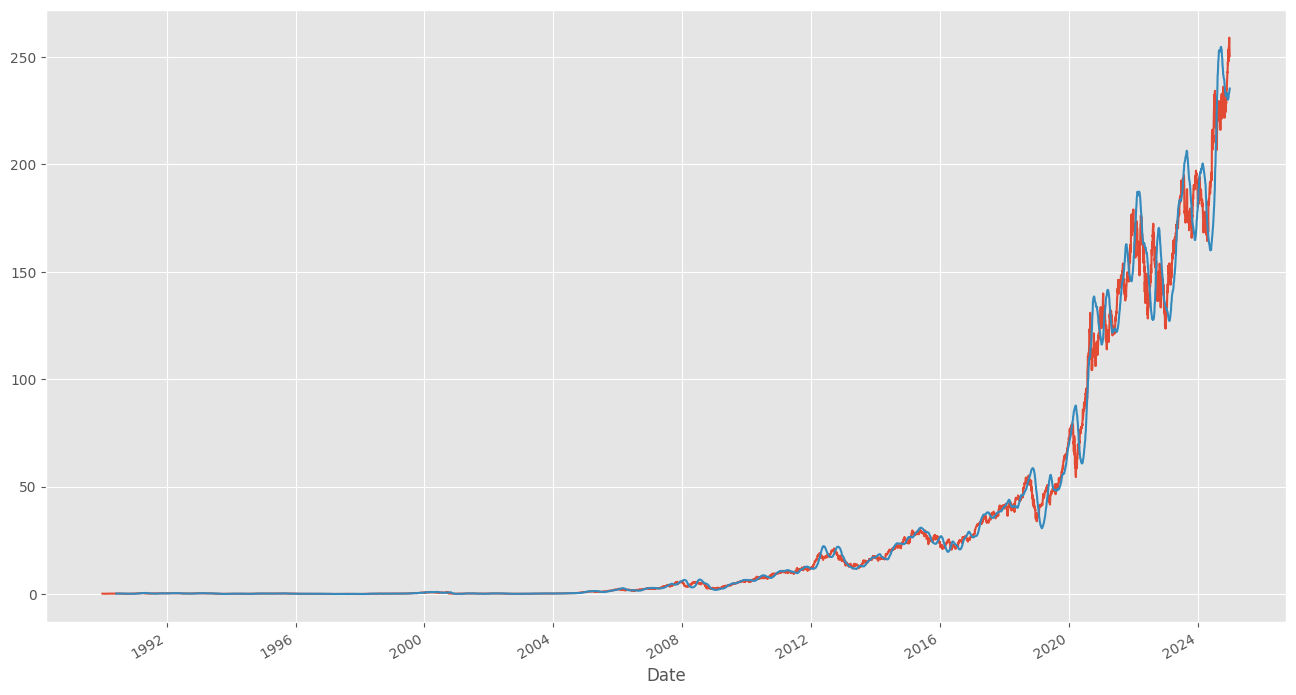

In [34]:
def plot_series(series: list[pd.Series], start_date: str=None, end_date: str=None):
    for serie in series:
        serie[start_date:end_date].plot()

plot_series([data, forecast])

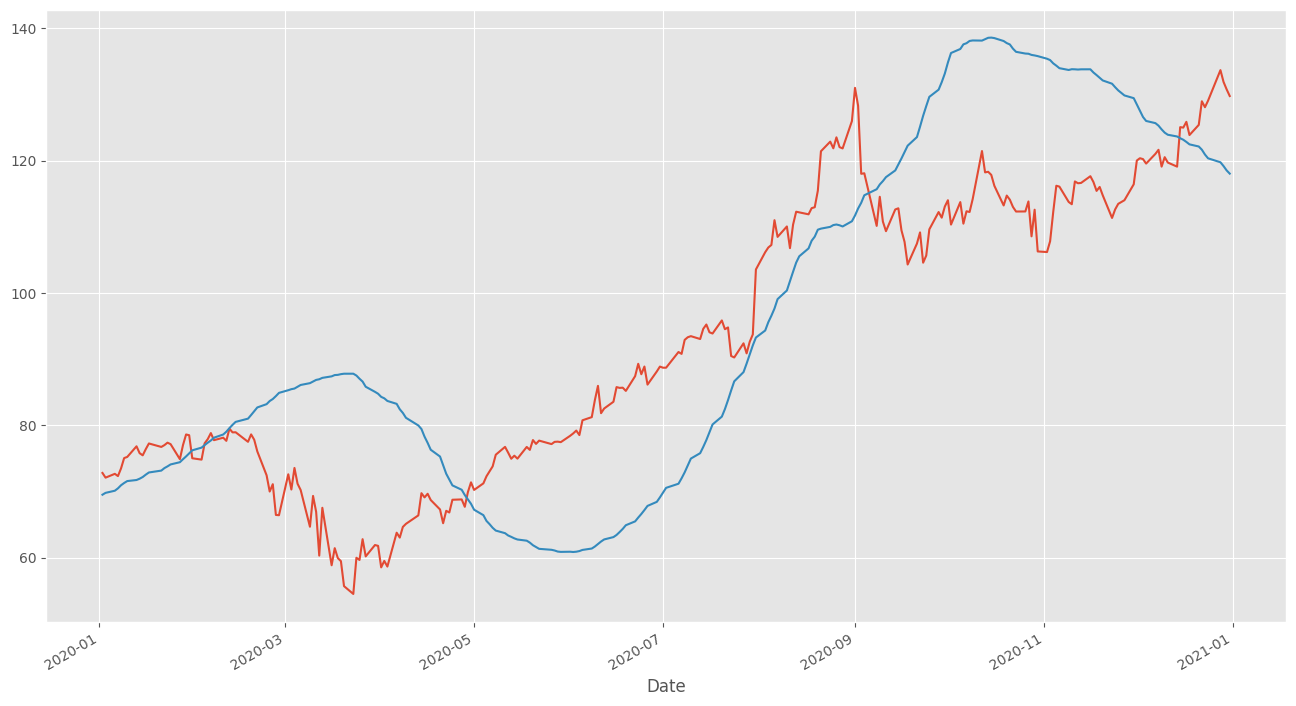

In [35]:
plot_series([data, forecast],'2020-01-01','2020-12-31')

In [36]:
from financial.lab.experiment import Experiment

prediction = forecast.dropna() 
target = data[horizon+lookahead:]

experiment = Experiment(experiment_id, prediction, target)
print(f"n = {experiment.samples()}")
print(f"MSE = {experiment.MSE():.4f}")
print(f"RMSE = {experiment.RMSE():.4f}")
print(f"MAE = {experiment.MAE():.4f}")
print(f"MAPE = {experiment.MAPE():.4f}")

n = 8707
MSE = 48.9561
RMSE = 6.9969
MAE = 2.8245
MAPE = 0.1377


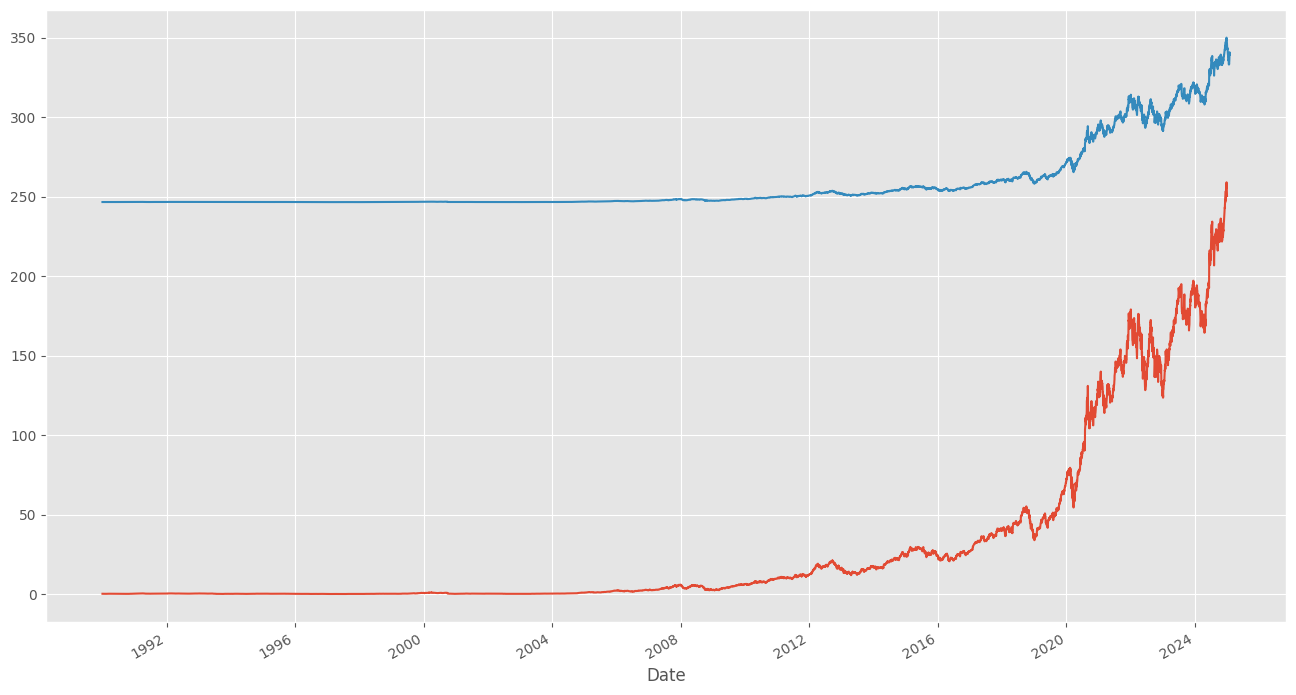

In [37]:
model_prediction = model.get_data(ds, start_date)

plot_series([data, model_prediction])

In [38]:
from sklearn.metrics import r2_score

r2 = r2_score(target, prediction)

print(f"R² = {r2:.4f}")


Indices target DatetimeIndex(['1990-06-08', '1990-06-11', '1990-06-12', '1990-06-13',
               '1990-06-14', '1990-06-15', '1990-06-18', '1990-06-19',
               '1990-06-20', '1990-06-21'],
              dtype='datetime64[ns]', name='Date', freq=None)
Indices prediction DatetimeIndex(['1990-06-08', '1990-06-11', '1990-06-12', '1990-06-13',
               '1990-06-14', '1990-06-15', '1990-06-18', '1990-06-19',
               '1990-06-20', '1990-06-21'],
              dtype='datetime64[ns]', name='Date', freq=None))
R² = 0.9834
